In [44]:
import pandas as pd
import prototype as pt
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

In [2]:
path_to_data = 'D:\\ubuntu\\zephyr_data\\'

In [36]:
import hashlib

def saveSnippetIntoFile(snippet):
    m = hashlib.sha256()
    m.update(snippet.encode('utf-8'))
    snippet_filename = m.hexdigest() + '.py'
    path_to_file = 'stable_snippets_files\\' + snippet_filename
    
    with open(path_to_data + path_to_file, 'w', encoding='utf-8') as f:
        f.write(snippet)
        f.close()
    return path_to_file

# Вычисление A-индекса

Для случайной подвыборки кода длины 10000 вычислим А-индекс.

In [4]:
#for chunk in pd.read_csv(path_to_data + 'stable_code_shuffled.csv', chunksize=10000):
#    chunk.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
#    chunk['path_to_file'] = chunk['before_merge'].apply(saveSnippetIntoFile)
#    anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
#                                                 for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'stable_snippets_files\\'))], 
#                                                columns =['a-index', 'path_to_file', 'message'])
#    df = chunk.join(anomaly_results.set_index('path_to_file'), on='path_to_file')
#    break

In [46]:
import pickle5 as pickle

pickle_file = open(path_to_data + 'stable_code_v2\\stable_dataset.pickle','rb')
data = pickle.load(pickle_file)

In [47]:
data = data.drop_duplicates('before_merge').sample(10000)
data.reset_index(inplace=True)

In [48]:
def decodeString(snippet):
    if not snippet:
        return np.nan
    try:
        return snippet.decode('utf-8')
    except UnicodeDecodeError:
        try:
            return snippet.decode('cp1251')
        except UnicodeDecodeError:
            print(snippet)



data['path_to_file'] = data['before_merge'].apply(decodeString).apply(saveSnippetIntoFile)

In [49]:
anomaly_results = pd.DataFrame.from_records([(item[3], item[0][22:], item[4])
                                            for item in pt.calc_anomalies(pt.get_python_paths(path_to_data + 'stable_snippets_files\\'))], 
                                            columns =['a-index', 'path_to_file', 'message'])
df = data.join(anomaly_results.set_index('path_to_file'), on='path_to_file')

In [62]:
df['before_merge'] = df['before_merge'].apply(decodeString)

In [63]:
df = df.loc[df['before_merge'].apply(lambda x: x is not None)]

# Анализ связи А-индекса с частотой часто встречающихся токенов

In [50]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [64]:
from collections import Counter

df['max_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x.most_common(1)[0][1])
df['max_G_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(Counter).apply(lambda x: x['Ġ'])

Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors


Видно, что частоты часто встречающихся токенов достаточно сильно коррелированы с А-индексом.

In [65]:
df[['a-index', 'max_token_occurence', 'max_G_token_occurence']].corr(method='spearman')

,a-index,max_token_occurence,max_G_token_occurence
a-index,1.000000,-0.633505,-0.653447
max_token_occurence,-0.633505,1.000000,0.984117
max_G_token_occurence,-0.653447,0.984117,1.000000


Построим диаграмму рассеяния.

In [67]:
import seaborn as sb
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

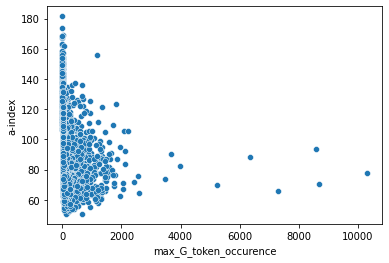

In [68]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df)

Уберем выбросы и снова построим

<AxesSubplot:xlabel='max_G_token_occurence', ylabel='a-index'>

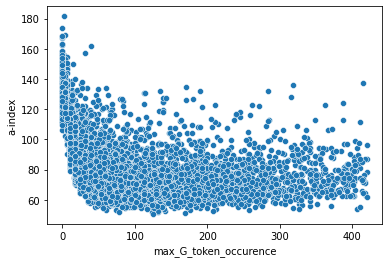

In [69]:
sb.scatterplot(x='max_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_G_token_occurence'] <= df['max_G_token_occurence'].quantile(q=0.95)])

# Анализ связи А-индекса с частотой подряд идущих токенов

Напишем функции для вычисления наибольших частот подряд идущих токенов.

In [70]:
from itertools import groupby

def computeMaxRepetitiveTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    return sorted(token_occurences, key=lambda x: x[1])[-1][1]

In [71]:
def computeMaxRepetitiveGTokenSequenceLength(tokenized_snippet):
    token_occurences = [(token, sum(1 for i in group_of_tokens)) for token, group_of_tokens in groupby(tokenized_snippet)]
    
    max_count = 0
    for token, count in sorted(token_occurences, key=lambda x: x[1]):
        if token == 'Ġ':
            max_count = max(max_count, count)    
    return max_count

Вычислим эти частоты.

In [72]:
df['max_consequtive_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveTokenSequenceLength)
df['max_consequtive_G_token_occurence'] = df['before_merge'].apply(tokenizer.tokenize).apply(computeMaxRepetitiveGTokenSequenceLength)

Подсчитаем корреляции.

In [73]:
df[['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.562578,-0.564666
max_consequtive_token_occurence,-0.562578,1.000000,0.998502
max_consequtive_G_token_occurence,-0.564666,0.998502,1.000000


Посмотрим на графики

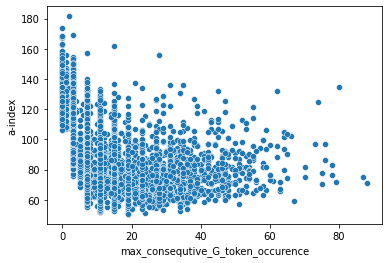

In [74]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df);

Посмотрим на связь с А-индексом при частоте символа G больше 20:

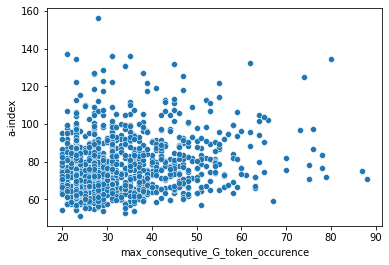

In [75]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] >= 20]);

Подсчитаем также корреляции по этой подвыборке

In [76]:
df.loc[df['max_consequtive_G_token_occurence'] >= 20][['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,0.125659,0.125659
max_consequtive_token_occurence,0.125659,1.000000,1.000000
max_consequtive_G_token_occurence,0.125659,1.000000,1.000000


Оценим какова длина этой подвыборки

In [77]:
df.loc[df['max_consequtive_G_token_occurence'] >= 20].shape[0] / 10000 * 100

11.379999999999999

Посмотрим на связь А-индекса с частотой для малых значений наибольшей частоты подряд идущих символов:

<AxesSubplot:xlabel='max_consequtive_G_token_occurence', ylabel='a-index'>

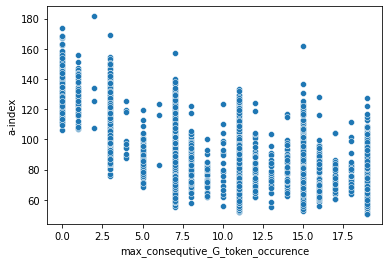

In [78]:
sb.scatterplot(x='max_consequtive_G_token_occurence',
               y='a-index',
               data=df.loc[df['max_consequtive_G_token_occurence'] < 20])

Оценим соответствующую корреляцию

In [79]:
df.loc[df['max_consequtive_G_token_occurence'] < 20][['a-index', 'max_consequtive_token_occurence', 'max_consequtive_G_token_occurence']].corr(method='spearman')

,a-index,max_consequtive_token_occurence,max_consequtive_G_token_occurence
a-index,1.000000,-0.622798,-0.625518
max_consequtive_token_occurence,-0.622798,1.000000,0.997827
max_consequtive_G_token_occurence,-0.625518,0.997827,1.000000


# Выводы

- частоты символа G отрицательно коррелированы с А-индексом;
- частоты подряд идущего символа G отрицательно коррелированы с А-индексом.

# Анализ связи А-индекса с некоторыми метриками кода

In [80]:
from radon.visitors import ComplexityVisitor
from radon.complexity import cc_rank
from radon.metrics import h_visit, mi_visit
from radon.raw import analyze
import numpy as np

Предварительная обработка сниппетов. Удаляем лишние пробелы.

In [81]:
import re

def checkExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    if number_of_spaces_to_remove > 0:
        return True

In [82]:
def removeExtraSpaces(snippet):
    number_of_spaces_to_remove = re.search('\S', snippet.split('\n')[0]).start(0)
    return '\n'.join([snippet_line[number_of_spaces_to_remove:] 
                      for snippet_line in snippet.split('\n')])

In [83]:
def refineSnippet(snippet):
    try:
        ComplexityVisitor.from_code(snippet)
        return snippet
    except:
        try:
            snippet_with_removed_extra_spaces = removeExtraSpaces(snippet)
            ComplexityVisitor.from_code(snippet_with_removed_extra_spaces)
            return snippet_with_removed_extra_spaces
        except:
            return np.nan

In [84]:
def compileSourceCode(snippet,
                      print_snippet=False):
    try:
        compile(snippet.strip(), 'file', 'exec')
        return True
    except SyntaxError as e:
        if ('no binding' not in e.msg) and ('unexpected indent' not in e.msg) and ('unindent' not in e.msg):
            print(e)
            if print_snippet:
                print(snippet)
            return False
        else:
            return True

Предобработка кода: удаление лишних пробелов и синтаксически некорректного кода.

In [85]:
df['before_merge_preprocessed'] = df['before_merge'].apply(removeExtraSpaces)
df['before_merge_preprocessed'] = df['before_merge_preprocessed'].apply(refineSnippet)
df['syntax_correct'] = df['before_merge'].apply(compileSourceCode)
df = df.loc[df['before_merge_preprocessed'].notna() & df['syntax_correct']]

invalid syntax (file, line 1)
invalid syntax (file, line 1)
unexpected EOF while parsing (file, line 15)
unexpected EOF while parsing (file, line 4)
EOF while scanning triple-quoted string literal (file, line 6)
unexpected EOF while parsing (file, line 3)
unexpected EOF while parsing (file, line 3)
unexpected EOF while parsing (file, line 6)
invalid syntax (file, line 1)
invalid syntax (file, line 6)
invalid syntax (file, line 1)
unexpected EOF while parsing (file, line 7)
unexpected EOF while parsing (file, line 7)
unexpected EOF while parsing (file, line 3)
unexpected EOF while parsing (file, line 3)


Функции вычисления метрик

In [86]:
def computeCyclomaticComplexity(snippet):
    return ComplexityVisitor.from_code(snippet).functions_complexity

In [87]:
def computeHastadMetrics(snippet):
    hastad_metrics = h_visit(snippet).total
    return {metric:getattr(hastad_metrics, metric) for metric in dir(hastad_metrics) 
            if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}

In [88]:
def computeRawMetrics(snippet):
    try:
        raw_metrics = analyze(snippet)
        return {metric:getattr(raw_metrics, metric) for metric in dir(raw_metrics) 
                if (not metric.startswith('_')) and ('index' not in metric) and ('count' not in metric)}
    except SyntaxError:
        return None

In [89]:
def computeMIindex(snippet):
    try:
        return mi_visit(snippet, multi=False)
    except SyntaxError:
        return np.nan

# Подсчет метрик

## Цикломатическая сложность

In [90]:
df['cc'] = df['before_merge_preprocessed'].apply(computeCyclomaticComplexity)

## Метрики Хастада

In [91]:
hastad_metrics = df['before_merge_preprocessed'].apply(computeHastadMetrics)

In [92]:
for col in hastad_metrics.loc[0].keys():
    df[col] = hastad_metrics.apply(lambda x: x[col])

## Сырые метрики

In [93]:
raw_metrics = df['before_merge_preprocessed'].apply(computeRawMetrics)

In [94]:
for col in raw_metrics.loc[0].keys():
    df[col] = raw_metrics.apply(lambda x: x[col] if x else np.nan)

## Индекс качества кода

In [95]:
df['MI'] = df['before_merge_preprocessed'].apply(computeMIindex)

# Связь с метриками

Формируем список всех метрик.

In [96]:
metric_names = ['cc', 'N1', 'N2', 'bugs', 'calculated_length', 'difficulty',
                'effort', 'h1', 'h2', 'length', 'time', 'vocabulary', 
                'volume', 'blank', 'comments', 'lloc', 'loc', 'multi',
                'single_comments', 'sloc', 'MI']

In [97]:
pd.set_option('display.max_columns', 500)

Подсчитаем корреляции

In [98]:
df[metric_names + ['a-index']].corr(method='spearman').round(2)

,cc,N1,N2,bugs,calculated_length,difficulty,effort,h1,h2,length,time,vocabulary,volume,blank,comments,lloc,loc,multi,single_comments,sloc,MI,a-index
cc,1.00,0.73,0.73,0.73,0.71,0.74,0.73,0.74,0.73,0.73,0.73,0.73,0.73,0.42,0.37,0.77,0.66,0.12,0.30,0.74,-0.72,-0.50
N1,0.73,1.00,1.00,1.00,0.97,0.99,1.00,0.99,0.99,1.00,1.00,1.00,1.00,0.40,0.36,0.66,0.59,0.11,0.29,0.65,-0.92,-0.38
N2,0.73,1.00,1.00,1.00,0.98,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.36,0.66,0.58,0.11,0.29,0.64,-0.92,-0.38
bugs,0.73,1.00,1.00,1.00,0.98,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.36,0.66,0.58,0.11,0.29,0.64,-0.92,-0.38
calculated_length,0.71,0.97,0.98,0.98,1.00,0.96,0.98,0.96,0.98,0.98,0.98,0.98,0.98,0.38,0.35,0.64,0.56,0.11,0.29,0.62,-0.89,-0.36
difficulty,0.74,0.99,0.99,0.99,0.96,1.00,0.99,1.00,0.98,0.99,0.99,0.99,0.99,0.39,0.36,0.65,0.58,0.11,0.29,0.64,-0.92,-0.38
effort,0.73,1.00,1.00,1.00,0.98,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.36,0.66,0.58,0.11,0.29,0.64,-0.92,-0.38
h1,0.74,0.99,0.99,0.99,0.96,1.00,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.39,0.36,0.65,0.57,0.11,0.29,0.63,-0.92,-0.39
h2,0.73,0.99,1.00,1.00,0.98,0.98,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.35,0.65,0.58,0.11,0.29,0.64,-0.92,-0.38
length,0.73,1.00,1.00,1.00,0.98,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.36,0.66,0.58,0.11,0.29,0.64,-0.92,-0.38


Вычислим медианные значения А-индекса при фиксированном значении метрик:

In [99]:
def groupedTargetMedian(data, 
                        feature_name, 
                        feature_value,
                        feature_std,
                        target_name):
    return data.loc[(data[feature_name] > feature_value - 0.1 * feature_std) &
                    (data[feature_name] < feature_value + 0.1 * feature_std), target_name].median(axis=0)

In [100]:
stds = df[metric_names].std(axis=0)

for metric_name in metric_names:
    df['a-index median given ' + metric_name + ' value'] = df[metric_name].apply(lambda x: 
                                                                                 groupedTargetMedian(df,
                                                                                                     metric_name,
                                                                                                     x,
                                                                                                     stds[metric_name],
                                                                                                     'a-index'))

Функция рисования графиков.

In [101]:
def plotScatterPlots(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.scatterplot(x=var_name, y='a-index', data=data)
            sb.scatterplot(x=var_name, y='a-index median given ' + var_name + ' value', data=data)
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

Показаны диаграммы рассеяния между А-индексом и метрикой, а также между медианой А-индекса и метрикой. Для более явной картины убрали выбросы.

In [102]:
df.loc[df['N1'] <= 100].shape[0] / df.shape[0] * 100

99.9697428139183

Показываются переменные 0 to 5 ...


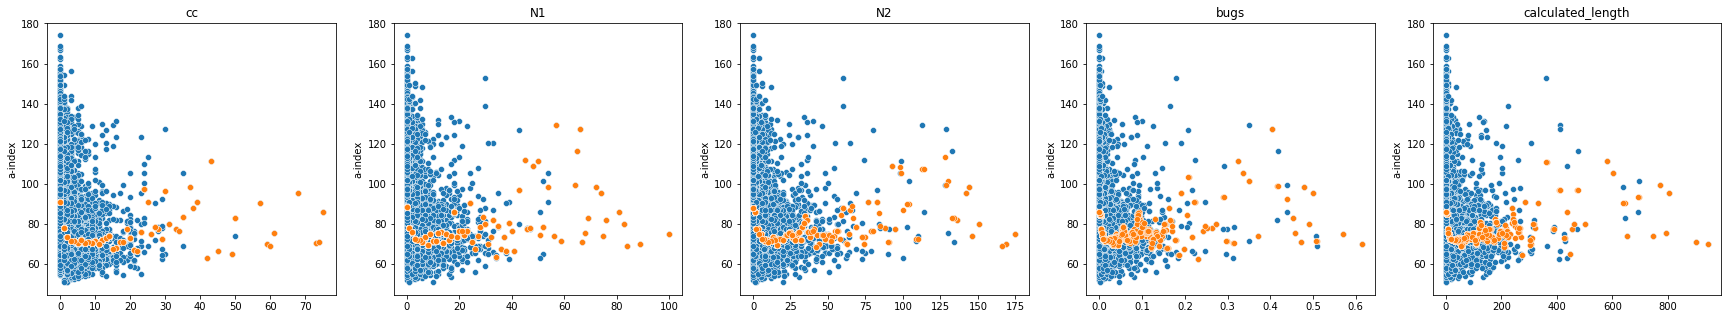

Показываются переменные 5 to 10 ...


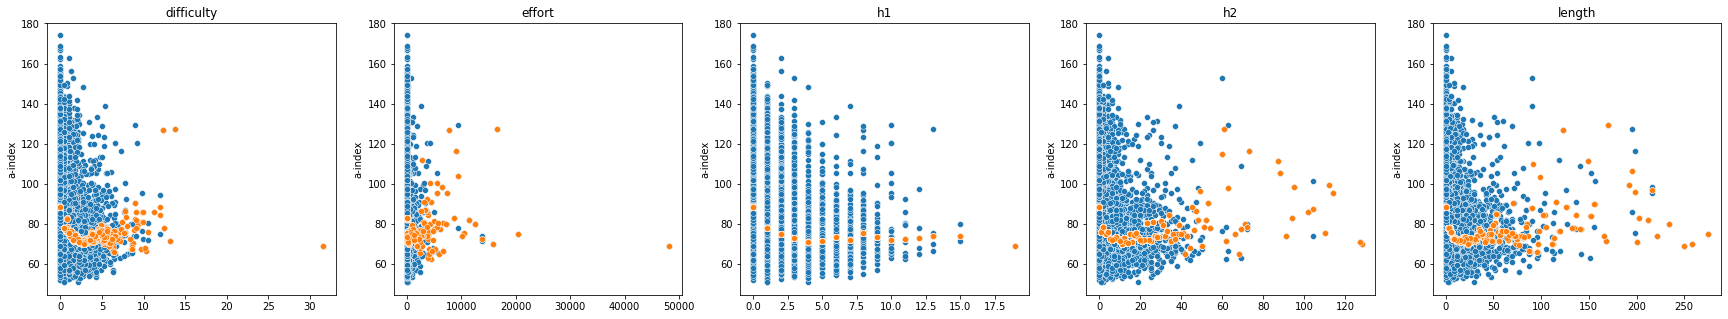

Показываются переменные 10 to 15 ...


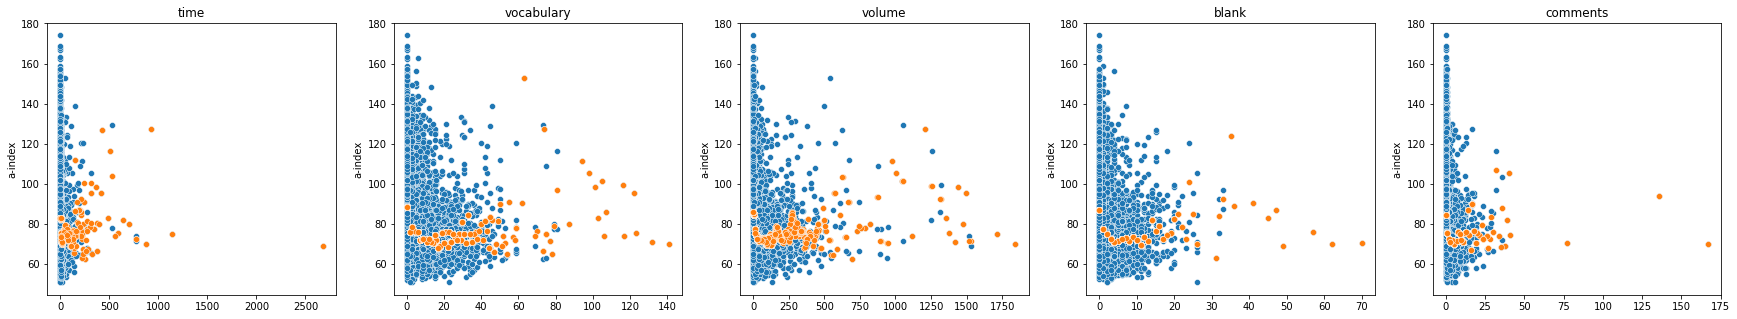

Показываются переменные 15 to 20 ...


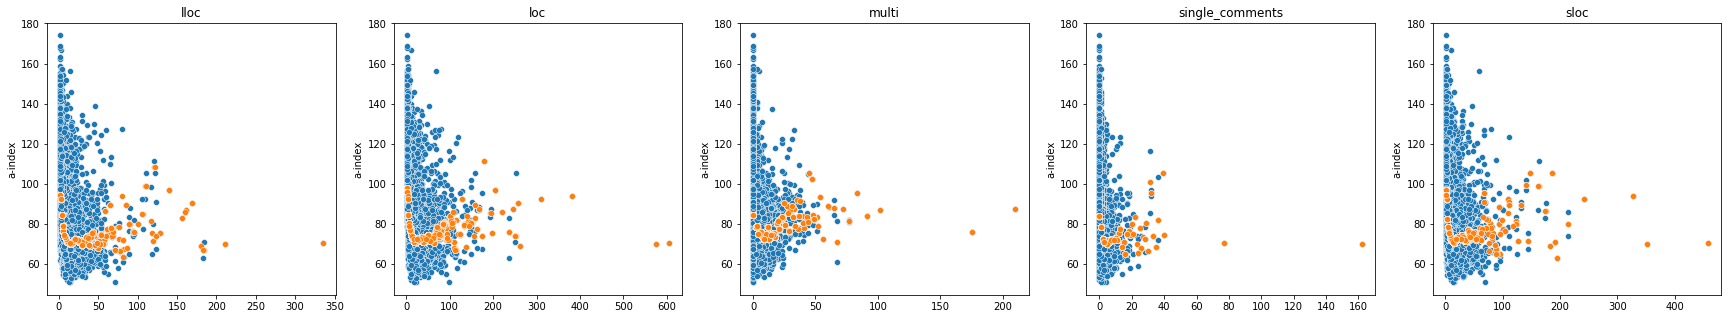

Показываются переменные 20 to 25 ...


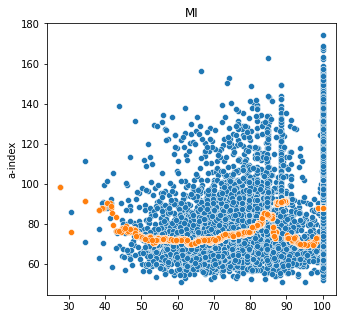

In [103]:
plotScatterPlots(df.loc[df['N1'] <= 100], metric_names)

In [105]:
def plotHistograms(data, features):
    # признаки разбиваются на группы по 5 штук, заводится
    # две переменных: var_group_id и var_within_group_id, указывающие
    # номер группы и номер внутри группы
    # графики выводятся группами по 5 признаков
    var_group_index = 0
    for var_group_id in range(len(features) // 5 + 1):
        # размер графика
        plt.figure(figsize = (30, 5))
        for var_within_group_id in range(5):
            # считаем абсолютный номер переменной: номер группы * 5 + номер внутри группы
            var_index = var_within_group_id + var_group_id * 5
            if var_index >= len(features):
                continue
            var_name = features[var_index]
            # % означает остаток от деления, var_group_index % 5 - остаток от деления на 5
            # в графике размера 1x5 активизируем поле с номером var_index % 5 + 1
            plt.subplot(1, 5, var_index % 5 + 1)
            sb.histplot(x=var_name, data=data, bins=100,
                        stat='count')
            # название поля в графике совпадает с названием переменной
            plt.title(var_name)
            plt.xlabel('')
            if (var_index % 5 == 0): print('Показываются переменные', var_index, 'to',var_index + 5,'...')
            #var_group_index += 1
        # выводим график на экран
        plt.show()
    return

In [116]:
df.drop('index', axis=1, inplace=True)

KeyError: "['index'] not found in axis"

In [122]:
df.drop_duplicates(inplace=True)

(9915, 59)

In [131]:
df = df.loc[~df.index.duplicated(), :]

Показываются переменные 0 to 5 ...


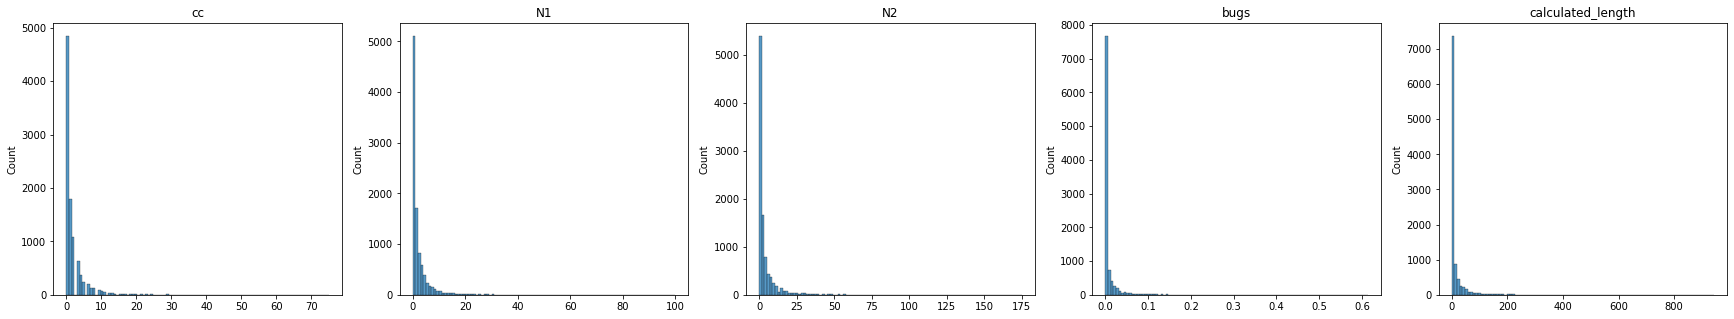

Показываются переменные 5 to 10 ...


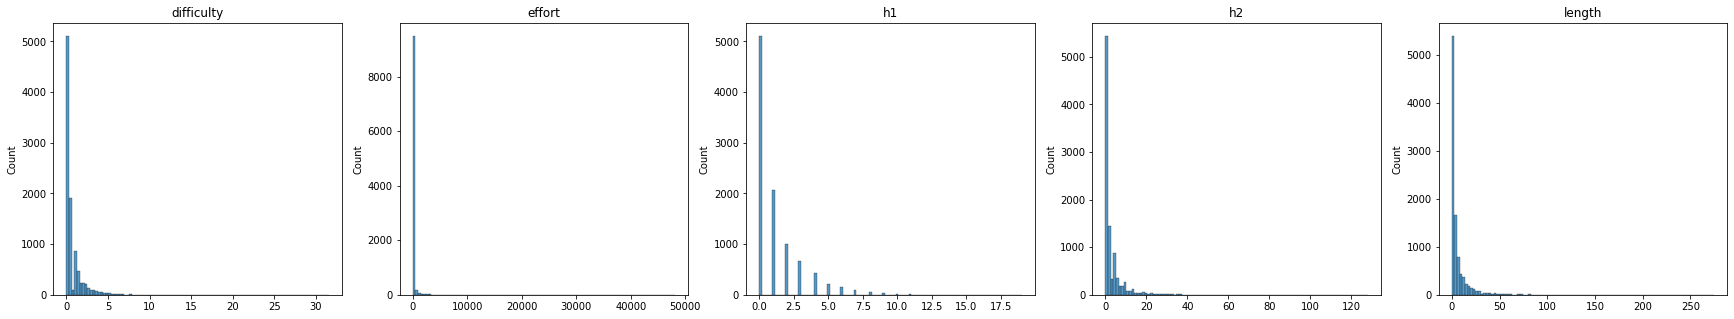

Показываются переменные 10 to 15 ...


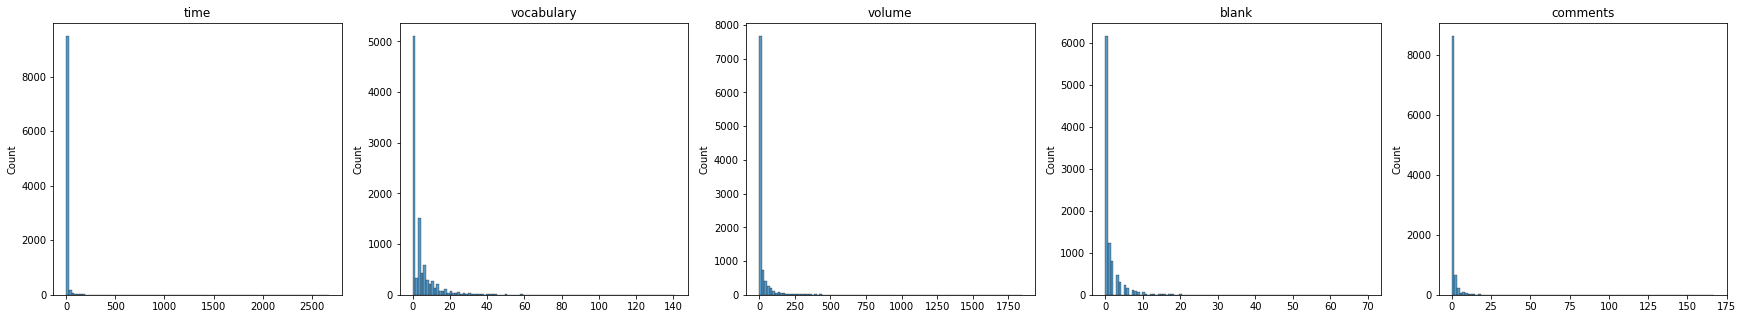

Показываются переменные 15 to 20 ...


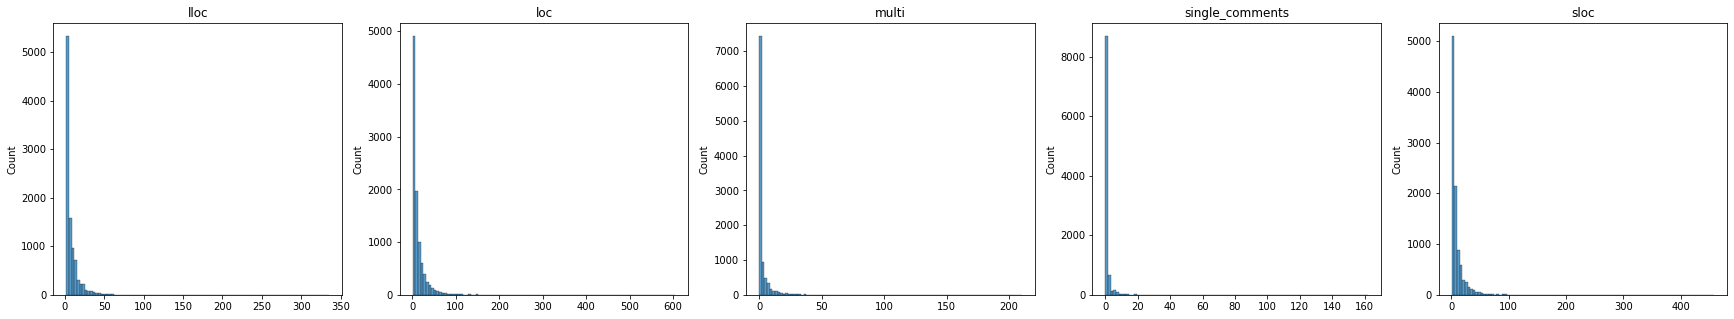

Показываются переменные 20 to 25 ...


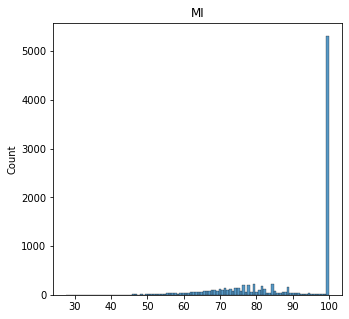

In [132]:
plotHistograms(df.loc[df['N1'] <= 100], metric_names);

# Выводы

- при росте значений метрик разброс аномальности быстро уменьшается за счет того что количество сниппетов с ростом значения метрик быстро убывает;
- для сниппетов малой длины и сложности разброс значений аномальности велик, среди них много аномальных сниппетов;

Посмотрим на связь метрик и аномальности для очень малых значений метрик, для которых достаточно много сниппетов.

Показываются переменные 0 to 5 ...


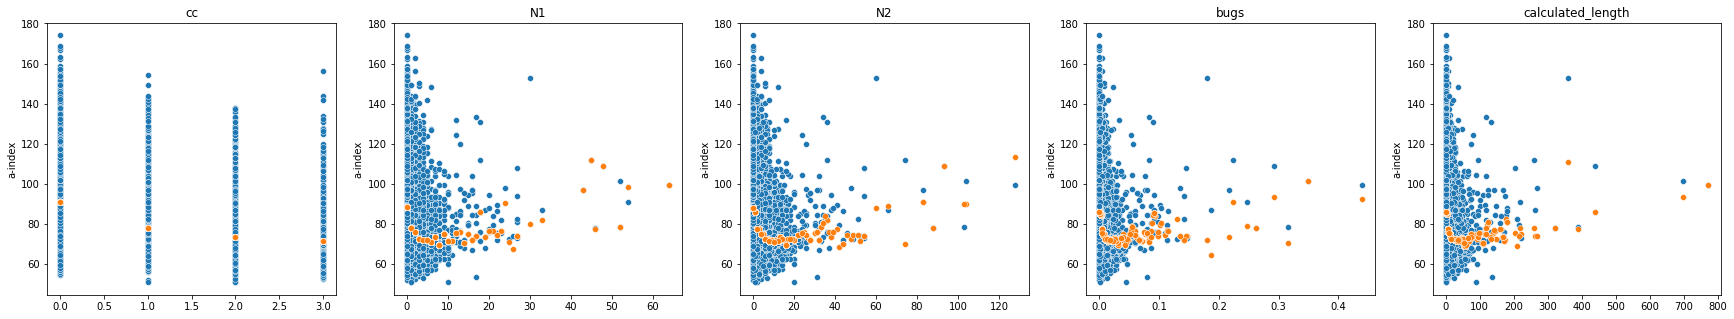

Показываются переменные 5 to 10 ...


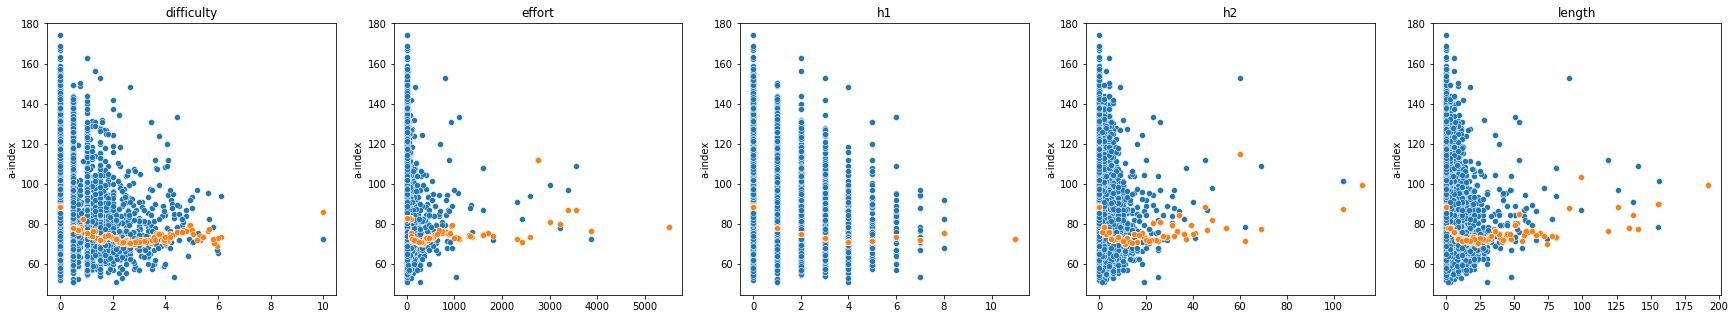

Показываются переменные 10 to 15 ...


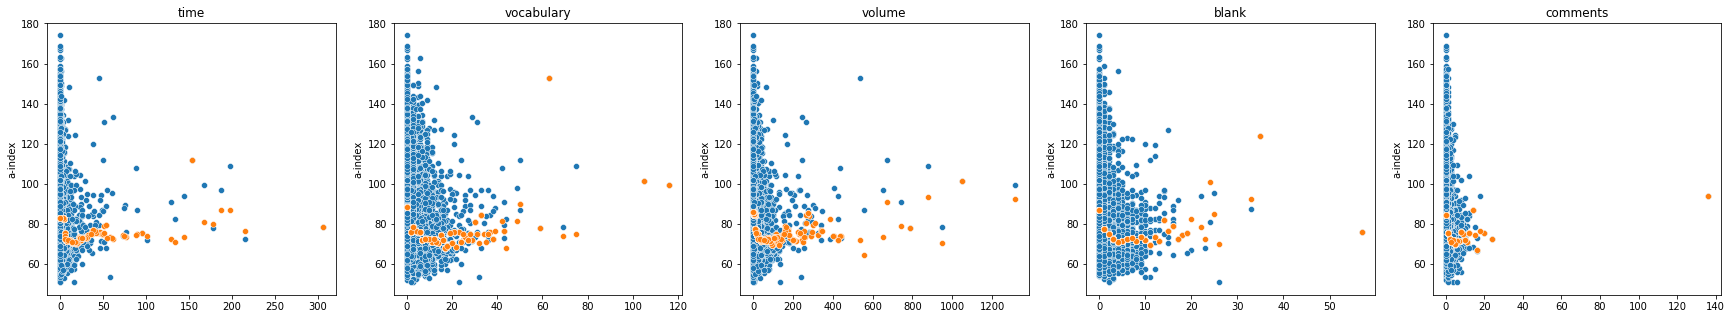

Показываются переменные 15 to 20 ...


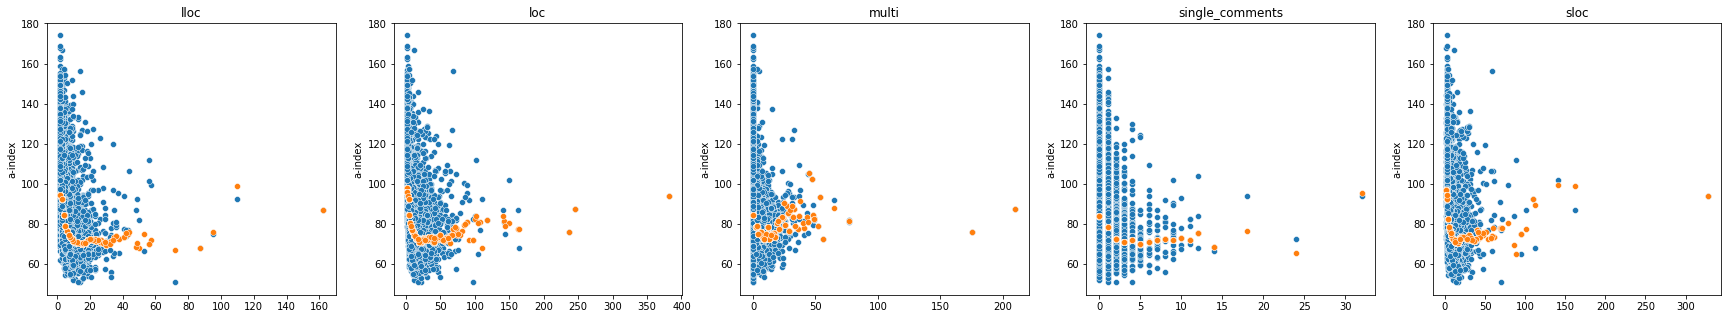

Показываются переменные 20 to 25 ...


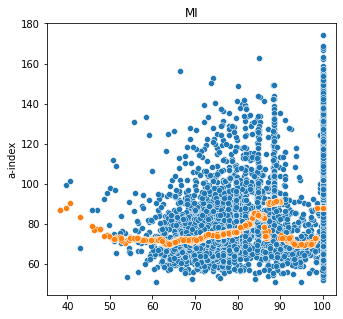

In [133]:
plotScatterPlots(df.loc[df['cc'] <= 3], metric_names)

# Выводы

Для малых значений метрик аномальность уменьшается с ростом сложности кода.

# Анализ распределения А-индекса

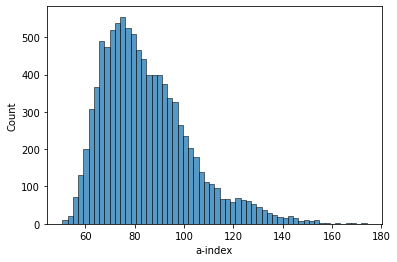

In [134]:
sb.histplot(x='a-index', data=df);

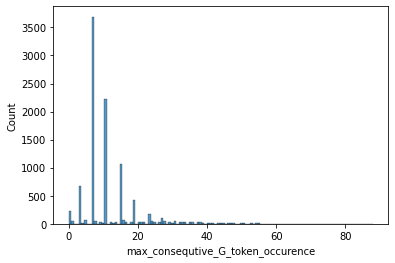

In [135]:
sb.histplot(x='max_consequtive_G_token_occurence', data=df);

# Анализ распределения А-индекса для короткого кода

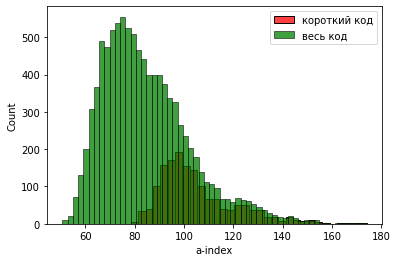

In [136]:
sb.histplot(x='a-index', data=df.loc[df['loc'] <=2], label='короткий код', color='r');
sb.histplot(x='a-index', data=df, label='весь код', color='g');
plt.legend();

Вмдно что короткий код имеет более высокий А-индекс.

In [101]:
pt.calc_anomalies(pt.get_python_paths('D:\\source\\git_projects\\zephyr\\anomaly\\sample_code\\'))

[('D:\\source\\git_projects\\zephyr\\anomaly\\sample_code\\dynamic_programming.py',
  0,
  py 0:25
  def longest_subsequence(array: list[int]) -> list[int]: 
      array_length = len(array)
      if array_length <= 1:
          return array
          # Else
      pivot = array[0]
      isFound = False
      i = 1
      longest_subseq = []
      while not isFound and i < array_length:
          if array[i] < pivot:
              isFound = True
              temp_array = [element for element in array[i:] if element >= array[i]]
              temp_array = longest_subsequence(temp_array)
              if len(temp_array) > len(longest_subseq):
                  longest_subseq = temp_array
          else:
              i += 1
  
      temp_array = [element for element in array[1:] if element >= pivot]
      temp_array = [pivot] + longest_subsequence(temp_array)
      if len(temp_array) > len(longest_subseq):
          return temp_array
      else:
          return longest_subseq,
  73.30092,